In [1]:
import numpy as np
np.seterr(divide='ignore')
from sklearn.linear_model import LinearRegression
import pmdarima as pm

# Linear regression

## Model formulation

In [2]:
data = np.load('3d_daily.npy')
data = data[:48, :48]
data.shape

(48, 48, 365)

In [3]:
t_past = 5
t_pre = 4

In [4]:
a = data.shape[0]
b = data.shape[1]
n = data.shape[2]
X = []
y = []

for i in range(a):
    for j in range(b):
        for k in range(n-t_past-t_pre+1):
            X.append([data[i, j, l] for l in range(k, k+5)])
            y.append([data[i, j, l+5] for l in range(k, k+4)])

In [5]:
print(f'Shape of X: {np.array(X).shape}')

Shape of X: (822528, 5)


In [6]:
X_train = []
X_test = []
y_train = []
y_test = []

for i in range(48**2):
    c = 365 * i
    X_train.extend(X[c:c+183])
    X_test.extend(X[c+183:c+365])
    y_train.extend(y[c:c+183])
    y_test.extend(y[c+183:c+365])

In [7]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of X_test: {X_test.shape}')

Shape of X_train: (412482, 5)
Shape of X_test: (410046, 5)


In [8]:
reg = LinearRegression().fit(X_train, y_train)
# print(f'Coefficients =\n{reg.coef_}\n')
# print(f'Intercepts = {reg.intercept_}\n')
# print(f'R^2 = {reg.score(X, y):.4f}')

## Evaluation

In [9]:
pre = reg.predict(X_test)
pre.shape

(410046, 4)

In [10]:
def mape_loss_func(pre, lbl, m):
    mask = pre > m
    return np.mean(eliminate_nan(np.fabs(lbl[mask]-pre[mask])/lbl[mask]))

def smape_loss_func(pre, lbl, m):
    mask = pre > m
    return np.mean(2*np.fabs(lbl[mask]-pre[mask])/(np.fabs(lbl[mask])+np.fabs(pre[mask])))

def mae_loss_func(pre, lbl, m):
    mask = pre > m
    return np.mean(np.fabs((lbl[mask]-pre[mask])))

def nrmse_loss_func(pre, lbl, m):
    mask = pre > m
    return np.sqrt(np.sum((pre[mask]-lbl[mask])**2)/pre[mask].flatten().shape[0])/(lbl[mask].max()-lbl[mask].min())

def nmae_loss_func(pre, lbl, m):
    mask = pre > m
    return np.mean(np.fabs((lbl[mask]-pre[mask]))) / (lbl[mask].max()-lbl[mask].min())

def eliminate_nan(b):
    a = np.array(b)
    c = a[~np.isnan(a)]
    c = c[~np.isinf(c)]
    return c

In [11]:
print(f'MAPE loss = {mape_loss_func(pre, y_test, 0):.4f}')
print(f'SMAPE loss = {smape_loss_func(pre, y_test, 0):.4f}')
print(f'MAE loss = {mae_loss_func(pre, y_test, 0):.4f}')
print(f'NRMSE loss = {nrmse_loss_func(pre, y_test, 0):.4f}')
print(f'NMAE loss = {nmae_loss_func(pre, y_test, 0):.4f}')

MAPE loss = 0.8577
SMAPE loss = 0.4265
MAE loss = 37.0483
NRMSE loss = 0.0342
NMAE loss = 0.0121


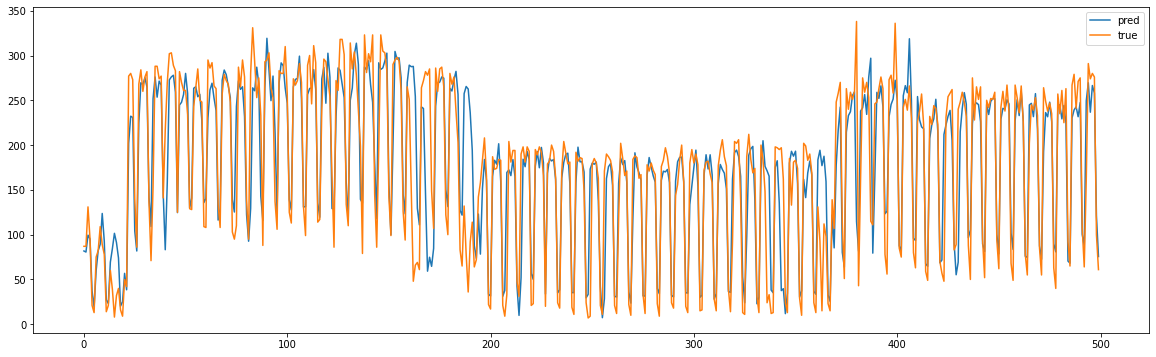

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=[20, 6])
plt.plot(pre[500:1000, 3], label='pred')
plt.plot(y_test[500:1000, 3], label='true')
plt.legend()